# DogeCoin Sentiment Analysis - Part A - Twitter #Dogecoin

In [1]:
import re
import nltk
from PIL import Image                                   # conda install -c anaconda pillow. This allows us to make masks in our word clouds
import webbrowser
import time 
import tweepy
import numpy as np
import pandas as pd    
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
from dotenv import load_dotenv
load_dotenv('john.env')

import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
C:\Users\jakel\anaconda3\envs\ml2env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
consumer_key = os.getenv('TWITTER_API')
consumer_secret = os.getenv('TWITTER_SECRET_KEY')

In [3]:
type(consumer_key)

str

In [4]:
# API Authentication 
callback_uri = 'oob'                                                      # declare a uniform resource indicator, and set to 'out-of-band'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret, callback_uri)   # creates an authentication object. stores our consumer and secret key. 
redirect_url = auth.get_authorization_url()                               # stores the API authorization url used to get a PIN number                             
webbrowser.open(redirect_url)                                             # Opens web and redirects you to Twitter app authorization website. Click Authorize and it provides a PIN number.
prompt = '>'                                                              # Enter the PIN number here. 
print('enter PIN number at the prompt. Hit enter.')
user_PIN = input(prompt)                                                  # enter the PIN number in prompt and now you'll have an access token. 
auth.get_access_token(user_PIN)                                           # Uses the PIN to generate an access token.
print('Your access key ', auth.access_token)                              # This key does not change regardless how many different PIN numbers you get.
print('The secret key ', auth.access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)                           # Create a tweepy API object with the access token. Set wait_on_rate_limit to reset after 15 minutes.

enter PIN number at the prompt. Hit enter.
Your access key  18325825-cHvbx5Kpg6HFjIrFYo8wfr8jheadKCXjUNQG57BvU
The secret key  Bk14J5TH5g4YmZvRmra7u23uwrkfwgWrNHHs0v4G0Ttby


In [5]:
# Set a variable to dogecoin hashtag.

search_t = '#dogecoin' 

In [6]:
# Search twitter based on the query we pass

posts = tweepy.Cursor(
    api.search,
    q=search_t,                # query is search_t which is for #dogecoin
    lang="en"
    ).items(1000)              # grab past 1000 tweets on the hashtag

In [7]:
# store all tweets in a raw DataFrame

all_tweets= [tweet.text for tweet in posts]

df = pd.DataFrame(
    all_tweets,
    columns=['Tweets']
)

df.shape

(1000, 1)

In [8]:
pd.set_option('display.max_colwidth', -1)
df.sample(10)

,Tweets
861,@beefy_musk Done\n\n0x0A5bF29a16bD38b49e375dC8eD2A5ACe901d7c4c\n\n#DogeCoin https://t.co/fbY4RufQdg
769,RT @greg16676935420: Easiest call of my life #dogecoin https://t.co/EqMZEKwjhV
50,"RT @TheOnlyFronk: Let's get #dogecoin trending! There is a massive update to #doge core code that will improve security, reduce fees to 0.0…"
444,Mondays got you down?? Well get in here and chill with the dogefam 🐕🐕🐕 🚀🚀😬😬 #doge #dogecoin #DogecoinRise #dogefam… https://t.co/rX9AwckJrh
284,RT @MilgateTyler: such a silly bunch of shibes 🤣💯\n\n#dogearmy #dogecoin #doge https://t.co/hE8mVRXnUi
624,RT @CoinMarketCap: What Is Baby Shiba Inu (BABYSHIBAINU)?\nhttps://t.co/jZfUOC1Sy2\n\nCoinMarketCap takes a deep dive into a dog-related meme…
513,"RT @Maicus81: “What can’t kill crypto, makes it stronger.” #dogecoin ✨ https://t.co/JMf9cOjvKD"
481,@MoonconnectNET Nice project 👍👍\n\n@ankitsomani6\n@coin_soi\n@MaityAnjali\n\n#MoonConnect #MoonConnectNET #presale #BNB… https://t.co/yKgk5doefk
799,RT @Dogemarine: Goooood Goooood let the doge flow through you\n#DoOnlyGoodEveryday #Dogecoin #crypto #memes https://t.co/le9OuxjLkA
103,"Yeah the ""INTERNET MONEY"" 🤣\n@GorillaGains1 @cryptopediaK7 @dogecoin @Moonwillycoin @safemoon @shiba_coin… https://t.co/vwr21JJQTJ"


## Clean up, apply subjectivity and polarity scores to each Tweet.

In [9]:
# Define some basic emoji's. We want to remove as many emoji's as possible to clean this data up.

#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
   ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [10]:
# Remove unwanted elements from the tweets

def clean_tweets(tweets):
    tweets = re.sub('@[A-Za-z0-9]+', '', tweets)                         # Removes the @ 
    tweets = re.sub('#', '', tweets)                                     # removes the hashtag #
    tweets = re.sub('RT[\s]+', '', tweets)                               # removes retweets RT
    tweets = re.sub('https?:\/\/\S+', '', tweets)                        # removes links
    tweets = emoji_pattern.sub(r'', tweets)                              # remove emojis based on            
    return tweets

# run the clean_tweets function on the Tweets column in the df
df.Tweets = df.Tweets.apply(clean_tweets)

# check if it cleaned up the tweets. 
pd.set_option('display.max_colwidth', -1)                                 # allows us to see full text 
df.sample(10)

,Tweets
812,": As we always do, we deliver!! We just flew an aerial banner on 's Tesla HQ and please see the video! Sup…"
655,_lee: Dogs love Cats dogecoin catecoin memes
884,Fingers crossed for a dogecoin\nBreak out!
652,Trash Mobile service when you use the GPS for more than 10 seconds.\n.\nretailbruddaz cryptocurrencies…
200,: The first ever coin dedicated to Satoshi Nakamoto!\nPrivate Sale Successful \nPresales Successful \nPublic Sale Ongoing …
739,: The latest $DOGE newsletter goes out in 30 MINUTES!\n\nIt explains all the latest DOGE news and explains why Dogecoin is F…
380,": See I did good today, a family friendly wholesome meme 🤣🤣🤣 \ndogecoin doge dogmoney dogefam dogearmy https…"
245,: Claim 1 WAX NFT FREE\n\nFollow Tasks For Giveaway\n1. Follow: \n2. Tag 3 Friends In Quote Tweet\n\nClaim NFT…
306,: Retweet if you want to see this again! To the mooooon \n dogecoin doge DogecoinToTheMoon DogecoinRise d…
731,I believe robinhood stock is gonna skyrocket as soon as they are done with cryptowallets. dogecoin bitcoin &lt; lame&gt; Ethereum


In [11]:
# subjectivity is nothing but a sentence that expresses some personal feelings, views, or beliefs. value ranges from 0-1. 0 is objective, and 1 is very subjective.tweepy

# adds subjectivity score to a Tweet
def calc_subj(tweet):
    return TextBlob(tweet).sentiment.subjectivity

# adds polarity score 
def calc_pola(tweet):
    return TextBlob(tweet).sentiment.polarity 

# Call and add subjective and polarity columns to the Dataframe
df['Subjectivity'] = df.Tweets.apply(calc_subj) 
df['Polarity'] = df.Tweets.apply(calc_pola)

df.head(10)

,Tweets,Subjectivity,Polarity
0,Patience is the key here. Hold on to your dogecoin. Mean while we will pump another coin soon. Coin name will be…,0.84375,-0.156250
1,I personally find this somewhat disturbing. I just am…,0.55000,-0.250000
2,: CybrrrDOGE is Top3 Trending Cryptocurrency in CoinMarketCap\n\n\n\ncybrrrdoge cyberdoge dogecoin …,0.00000,0.000000
3,_bdoge: Famous quote from \n\n“I think it is possible for ordinary people to choose to be extraordinary.” Cryptocurency b…,0.87500,0.145833
4,: linkedin twitter facebook instagram tumblr socialmedia onlineshop pinterest dogecoin reddit gift gifts gi…,0.00000,0.000000
5,: What Is Baby Shiba Inu (BABYSHIBAINU)?\n\n\nCoinMarketCap takes a deep dive into a dog-related meme…,0.40000,0.000000
6,": 10,000 $DOGE Giveaway \nTo Enter\n Just Like, Retweet And Follow Me &amp; \n Comment dogearmy \n\ndoge dogecoin…",0.00000,0.000000
7,_musk: 24 Hours | DogeCoin Giveaway 🤍\n\nFollow me \nthis \nFollow \n\n Good Luck,0.60000,0.700000
8,: What Is Baby Shiba Inu (BABYSHIBAINU)?\n\n\nCoinMarketCap takes a deep dive into a dog-related meme…,0.40000,0.000000
9,": “What can’t kill crypto, makes it stronger.” dogecoin",0.00000,0.000000


In [12]:
# Function to assign a label of the polarity score column.
def sentiment(polarity):
    result = ''
    if polarity > 0:
        result = 'Positve'
    elif polarity == 0:
        result = 'Neutral'
    else:
        result = 'Negative'
    return result

# Add a sentiment column and call sentiment function to assign a sentiment label to the numeric polarity score.
df['Sentiment'] = df.Polarity.apply(sentiment)

df.head()

,Tweets,Subjectivity,Polarity,Sentiment
0,Patience is the key here. Hold on to your dogecoin. Mean while we will pump another coin soon. Coin name will be…,0.84375,-0.156250,Negative
1,I personally find this somewhat disturbing. I just am…,0.55000,-0.250000,Negative
2,: CybrrrDOGE is Top3 Trending Cryptocurrency in CoinMarketCap\n\n\n\ncybrrrdoge cyberdoge dogecoin …,0.00000,0.000000,Neutral
3,_bdoge: Famous quote from \n\n“I think it is possible for ordinary people to choose to be extraordinary.” Cryptocurency b…,0.87500,0.145833,Positve
4,: linkedin twitter facebook instagram tumblr socialmedia onlineshop pinterest dogecoin reddit gift gifts gi…,0.00000,0.000000,Neutral


In [38]:
# Count the sentiment labels.

dff = pd.DataFrame(df['Sentiment'].value_counts()).reset_index()#.T
dff

,index,Sentiment
0,Neutral,527
1,Positve,397
2,Negative,76


In [39]:
import plotly.express as px
fig = px.pie(dff, values ='Sentiment', names ='index' )
fig.show()

In [ ]:
dic = [['Neutral', ]]

In [14]:
# Save the Tweets to a CSV file

df.to_csv('dogecoin_twitter_feed_5.csv')

In [17]:
df.head()

,Tweets,Subjectivity,Polarity,Sentiment
0,Patience is the key here. Hold on to your dogecoin. Mean while we will pump another coin soon. Coin name will be…,0.84375,-0.156250,Negative
1,I personally find this somewhat disturbing. I just am…,0.55000,-0.250000,Negative
2,: CybrrrDOGE is Top3 Trending Cryptocurrency in CoinMarketCap\n\n\n\ncybrrrdoge cyberdoge dogecoin …,0.00000,0.000000,Neutral
3,_bdoge: Famous quote from \n\n“I think it is possible for ordinary people to choose to be extraordinary.” Cryptocurency b…,0.87500,0.145833,Positve
4,: linkedin twitter facebook instagram tumblr socialmedia onlineshop pinterest dogecoin reddit gift gifts gi…,0.00000,0.000000,Neutral


## Visualizations

In [19]:
# Graph the count of all the polarity labels in a bar graph.

df['Sentiment'].value_counts.plot(kind='bar', color='red', title='Sentiment Classification')

AttributeError: 'function' object has no attribute 'plot'

In [ ]:
df2

Text(0, 0.5, 'Subjectivity')

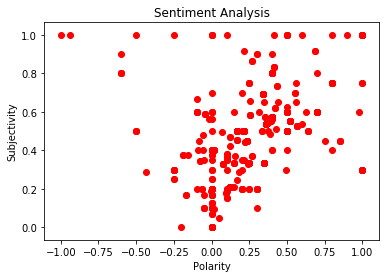

In [44]:
# Scatter plot of the polarity numeric scores.

plt.scatter(df.Polarity, df.Subjectivity, color='red')
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')                      # 0.00 is neutral
plt.ylabel('Subjectivity')

In [45]:
# Sentiment label breakdown, total, percentage 

# Create a sentiment dataframe. 
df_sentiment = pd.DataFrame(
    df.Sentiment.value_counts(normalize=True)*100 
)

# Add a column called total. Set to the value counts of the df.Sentiment column.
df_sentiment['Total'] = df.Sentiment.value_counts() 

df_sentiment['Percentage'] = df.Sentiment.value_counts() / 100 * 100                         # the percentage column should total 100 percent. this is not calculatiing correctly. 


df_sentiment


,Sentiment,Total,Percentage
Positve,51.5,515,515.0
Neutral,43.6,436,436.0
Negative,4.9,49,49.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


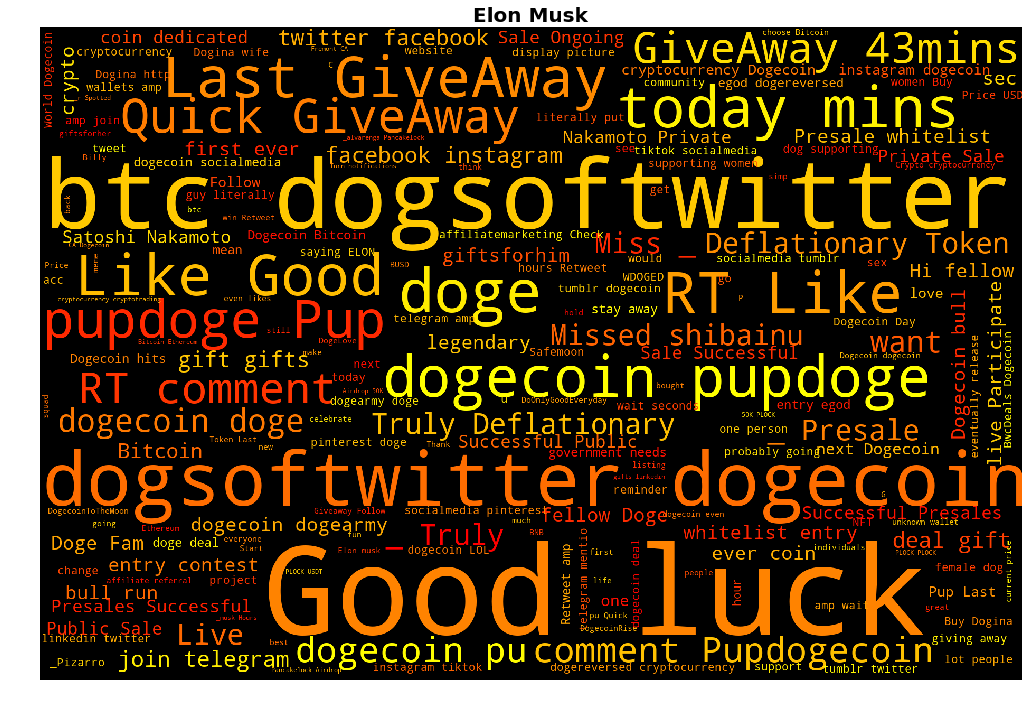

In [46]:
# create stopwords
nltk.download('stopwords')
stpwrd = set(nltk.corpus.stopwords.words('english'))

# Combining all tweets text
allWords = ' '.join([twts for twts in df['Tweets']])

# Bring in an image of Elon as a mask to shape our word cloud.
mask = np.array(Image.open("elon_m.jpg"))


# Define a function WC to make word cloud.

def WC(data, title, mask=None):
    wc =  WordCloud(                              # make a WordCloud object.
        width = 500,
        height = 500,
        scale=3,
        random_state=21,
        colormap='autumn',
        mask=mask,
        stopwords=stpwrd,
        collocations=True
    ).generate(data)                                # take the allWords and generate cloud based on that. 

    plt.figure(figsize=(20,12))
    #Cloud.to_file(str(title)+'.png') 
    plt.imshow(wc)
    plt.axis('off')
    fontdict = {'fontsize' : 20, 'fontweight' : 'bold'}
    plt.title(title, fontdict=fontdict)
    plt.show()                                      # no return statement???? 

# call the WC function, pass 

WC(allWords, 'Elon Musk', mask=mask)              # no word cloud is produced by this line. 


## Tokenizing the Words

In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation